# PC Game Recommendations -  Content Based and Collaborative Recommenders for Steam

## Overview

## Business Understanding

Steam is the most popular digital distribution service and store for PC games. While physical discs were once the norm for PC game sales, digital downloads have become the standard. Steam offers a platform for users to manage their library of game with access to services such as cloud saves and community features. In 2021, Steam averaged around 69 million daily active players. 

Recommender systems are important to online stores to engage consumers with products that would interest them and have the highest likelihood of being purchased. Steam has various recommender systems in their store. There are content based systems (based on what the user has played) as well as collaborative systems (based on similar users or friends of the user have played). 

My goal with this project was to leverage data from Steam in order to build recommender models. I used content labels - categories, genres, and tags - to provide content based recommendations. For a collaborative recommender, I utilized playtime as an implicit rating. Steam's rating system is binary, either Recommended/Not Recommended. As a metric, playtime reflects a user's engagement with a game. I compared users based on their game playtimes to come up with a collaborative recommender that predicts how much time a player might spend on a game. 

# Data Understanding

I used two different datasets to build my recommendation models. The content based recommender uses a dataset from Kaggle, while the collaborative recommender uses data I collected from Steam's Web API.

In [1]:
#import statements
#import statements
import numpy as np
import pandas as pd
import json
import requests
from operator import itemgetter

import matplotlib
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer

from surprise import accuracy, BaselineOnly, Dataset, KNNBasic, Reader, SVD, SVDpp, NormalPredictor

from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

# Content-Based Recommender

### Steam Store Games  - Kaggle Dataset

For my content-based recommender, I used a dataset from Kaggle containing information on video game categories and genres. The dataset can be found [here](https://www.kaggle.com/datasets/nikdavis/steam-store-games?select=steamspy_tag_data.csv).

The author documented their process of data collection via Steam Web API calls and SteamSpy API calls. This [link](https://nik-davis.github.io/posts/2019/steam-data-collection/) goes into how the author collected and cleaned the dataset.

The dataset can be found in this repository in the data folder within the Steam_store_data subfolder.

In [2]:
steam_df = pd.read_csv('./data/Steam_store_data/steam.csv')

In [3]:
steam_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27075 entries, 0 to 27074
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   appid             27075 non-null  int64  
 1   name              27075 non-null  object 
 2   release_date      27075 non-null  object 
 3   english           27075 non-null  int64  
 4   developer         27075 non-null  object 
 5   publisher         27075 non-null  object 
 6   platforms         27075 non-null  object 
 7   required_age      27075 non-null  int64  
 8   categories        27075 non-null  object 
 9   genres            27075 non-null  object 
 10  steamspy_tags     27075 non-null  object 
 11  achievements      27075 non-null  int64  
 12  positive_ratings  27075 non-null  int64  
 13  negative_ratings  27075 non-null  int64  
 14  average_playtime  27075 non-null  int64  
 15  median_playtime   27075 non-null  int64  
 16  owners            27075 non-null  object

Here are brief descriptions for each column:
* appid : Unique identifier for each game on Steam
* name : title of app(game)
* release_date : release date in YYYY-MM-DD formate
* english : 1 if game is in English, otherwise 0
* developer : name(s) of developer(s), delimited by semicolon if multiple devs
* publisher : name(s) of publisher(s), delimited by semicolon if multiple publishers
* platforms : supported platforms (includes Windows, Mac, and Linux), delimited by semicolon
* required_age : minimum required age based on PEGI UK ratings, 0 denotes unrated or unsupplied
* categories : game categories, delimited by semicolon
* genres: game genres, delimited by semicolon
* steamspy_tags: community voted tags, delimited by semicolon
* achievements : number of in-game achievements
* positive_ratings : number of positive ratings (from SteamSpy)
* negative_ratings : number of negative ratings (from SteamSpy)
* average_playtime : average user playtime in minutes (from SteamSpy)
* median_playtime : median user playtime in minutes (from SteamSpy)
* owners: estimated number of owners given as a range
* price : full price of title in GBP

### Exploring the Data 

In [4]:
steam_df.head(10)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99
5,60,Ricochet,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Valve Anti-Ch...,Action,Action;FPS;Multiplayer,0,2758,684,175,10,5000000-10000000,3.99
6,70,Half-Life,1998-11-08,1,Valve,Valve,windows;mac;linux,0,Single-player;Multi-player;Online Multi-Player...,Action,FPS;Classic;Action,0,27755,1100,1300,83,5000000-10000000,7.19
7,80,Counter-Strike: Condition Zero,2004-03-01,1,Valve,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,Action;FPS;Multiplayer,0,12120,1439,427,43,10000000-20000000,7.19
8,130,Half-Life: Blue Shift,2001-06-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player,Action,FPS;Action;Sci-fi,0,3822,420,361,205,5000000-10000000,3.99
9,220,Half-Life 2,2004-11-16,1,Valve,Valve,windows;mac;linux,0,Single-player;Steam Achievements;Steam Trading...,Action,FPS;Action;Sci-fi,33,67902,2419,691,402,10000000-20000000,7.19


In [5]:
steam_df.shape

(27075, 18)

There are 27,705 rows - each representing a game or app in Steam's store - and 18 columns.

Let's go through each column one-by-one:

In [6]:
#unique id for each game
steam_df['appid']

0             10
1             20
2             30
3             40
4             50
          ...   
27070    1065230
27071    1065570
27072    1065650
27073    1066700
27074    1069460
Name: appid, Length: 27075, dtype: int64

In [7]:
steam_df['appid'].value_counts()

397310    1
272270    1
710480    1
640850    1
431960    1
         ..
875710    1
563810    1
244930    1
298180    1
655360    1
Name: appid, Length: 27075, dtype: int64

'appid' is a unique identifier of a game in the dataset. No two games will have the same 'appid'.

In [8]:
#name of app/game
steam_df['name']

0                    Counter-Strike
1             Team Fortress Classic
2                     Day of Defeat
3                Deathmatch Classic
4         Half-Life: Opposing Force
                    ...            
27070               Room of Pandora
27071                     Cyber Gun
27072              Super Star Blast
27073    New Yankee 7: Deer Hunters
27074                     Rune Lord
Name: name, Length: 27075, dtype: object

In [9]:
steam_df['name'].value_counts()

Dark Matter          3
Zombie Apocalypse    2
Exodus               2
The Great Escape     2
Cortex               2
                    ..
Nanuleu              1
Kunoichi Botan       1
Magnetis             1
Marble Combat        1
World War II GI      1
Name: name, Length: 27033, dtype: int64

'name' is not a unique identifier for games. There are a few games with the same name. 

In [10]:
steam_df[steam_df['name'] == 'Dark Matter']

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
1975,251410,Dark Matter,2013-10-17,1,InterWave Studios,Iceberg Interactive,windows;mac;linux,0,Single-player;Steam Achievements;Full controll...,Action;Indie,Action;Indie;Side Scroller,17,78,107,0,0,0-20000,6.99
4673,345130,Dark Matter,2015-02-27,1,Meridian4,Meridian4,windows,0,Single-player;Partial Controller Support,Action;Casual;Indie,Action;Casual;Indie,0,75,50,0,0,100000-200000,3.99
21986,850250,Dark Matter,2018-05-04,1,Barty Games,Barty Games,windows,0,Single-player;Steam Achievements,Action;Indie,Action;Indie,3,3,3,0,0,0-20000,0.79


In [11]:
steam_df[steam_df['name'] == 'Dark Matter'].index

Int64Index([1975, 4673, 21986], dtype='int64')

The dataset included some downloadable content ('DLC') listed as a separate product. Since DLC content are add-ons to games, the similarity between a DLC and its base game is likely very high. However, the recommender should not include DLC. Steam's platform already shows users what DLC is available for games in their library. Additionally, DLC is not usable unless you own the base game. 

I searched for several key substrings within the 'name' column to search for DLC. 

In [12]:
#only one game contains DLC and it is actually a distinct game
steam_df[steam_df['name'].str.contains('DLC')]

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
1627,230050,DLC Quest,2013-03-18,1,Going Loud Studios,Going Loud Studios,windows;mac,0,Single-player;Steam Achievements;Steam Trading...,Indie,Platformer;Indie;Satire,22,5434,718,126,139,200000-500000,1.99


In [13]:
steam_df[steam_df['name'].str.contains('dlc')]

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price


In [14]:
steam_df[steam_df['name'].str.contains('Add-on')]

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price


In [15]:
pack = steam_df[steam_df['name'].str.contains('Pack')]
pack

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
53,2330,QUAKE II Mission Pack: The Reckoning,2007-08-03,1,Xatrix Entertainment,id Software,windows,0,Single-player;Multi-player;Steam Cloud,Action,Action;FPS;Classic,0,65,12,32,32,200000-500000,2.49
54,2340,QUAKE II Mission Pack: Ground Zero,2007-08-03,1,Rogue Entertainment,id Software,windows,0,Single-player;Multi-player;Steam Cloud,Action,Action;FPS;Shooter,0,54,33,1,1,200000-500000,2.49
226,9030,QUAKE Mission Pack 2: Dissolution of Eternity,2007-08-03,1,Rogue Entertainment,id Software,windows,0,Single-player;Multi-player;Steam Cloud,Action,Action;FPS;Shooter,0,143,15,88,91,200000-500000,2.49
227,9040,QUAKE Mission Pack 1: Scourge of Armagon,2007-08-03,1,Ritual Entertainment,id Software,windows,0,Single-player;Multi-player;Steam Cloud,Action,Action;FPS;Shooter,0,205,13,129,152,200000-500000,2.49
406,17440,SPORE™ Creepy & Cute Parts Pack,2008-12-19,1,Maxis™,Electronic Arts,windows,0,Single-player,Simulation,Simulation;Adventure;Open World,0,481,100,171,240,500000-1000000,9.99
599,32470,STAR WARS™ Empire at War - Gold Pack,2010-05-25,1,Petroglyph,LucasArts;Lucasfilm;Disney Interactive,windows,0,Single-player;Multi-player;Online Multi-Player...,Strategy,Strategy;Star Wars;RTS,0,6526,396,395,219,1000000-2000000,15.49
676,36130,Tradewinds Caravans + Odyssey Pack,2009-07-17,1,Sandlot Games,Sandlot Games,windows,0,Single-player,Casual,Casual,0,4,1,0,0,0-20000,10.99
704,37400,"Time Gentlemen, Please! and Ben There, Dan Tha...",2009-08-25,1,Size Five Games,Size Five Games,windows,0,Single-player,Adventure;Indie,Point & Click;Adventure;Indie,0,494,118,10,10,200000-500000,2.99
709,37960,Jewel Quest Pack,2009-08-24,1,iWin,iWin,windows,0,Single-player,Casual,Casual;Puzzle;Match 3,0,19,3,0,0,0-20000,14.99
1299,207400,eXceed 3rd - Jade Penetrate Black Package,2012-08-02,1,Tennen-sozai,Nyu Media,windows,0,Single-player;Steam Trading Cards,Action,Bullet Hell;Anime;Shoot 'Em Up,0,489,41,127,141,50000-100000,4.79


In [16]:
pack.shape

(32, 18)

In [17]:
pack['name']

53                    QUAKE II Mission Pack: The Reckoning
54                      QUAKE II Mission Pack: Ground Zero
226          QUAKE Mission Pack 2: Dissolution of Eternity
227               QUAKE Mission Pack 1: Scourge of Armagon
406                        SPORE™ Creepy & Cute Parts Pack
599                   STAR WARS™ Empire at War - Gold Pack
676                     Tradewinds Caravans + Odyssey Pack
704      Time Gentlemen, Please! and Ben There, Dan Tha...
709                                       Jewel Quest Pack
1299             eXceed 3rd - Jade Penetrate Black Package
1756                             The Apogee Throwback Pack
2281                                        Red Baron Pack
2685                                  Carmageddon Max Pack
2777           RollerCoaster Tycoon® 2: Triple Thrill Pack
3059             Putt-Putt® and Fatty Bear's Activity Pack
4145                                The Jackbox Party Pack
4839                               Fruits Inc. Deluxe Pa

Searching for 'pack' within the app name yielded a list of possible DLCs. Since there were only 32 instances, I manually went through Steam's store to determine what was considered a game and was was considered DLC. Most of these games were game bundles ("packs") and were not removed. Some of these apps were no longer available on the store so these were also removed.

In [18]:
#a list of indices of dlc content to remove from the dataset
dlc_list = [53, 54, 226, 227, 406]

In [19]:
edition = steam_df[steam_df['name'].str.contains('Edition')]
edition

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
43,1930,Two Worlds Epic Edition,2009-04-30,1,Reality Pump Studios,Topware Interactive,windows;mac;linux,0,Single-player;Multi-player;Online Multi-Player...,RPG,RPG;Open World;Fantasy,0,2656,1055,484,422,1000000-2000000,6.99
103,3590,Plants vs. Zombies GOTY Edition,2009-05-05,1,"PopCap Games, Inc.","PopCap Games, Inc.",windows;mac,0,Single-player;Steam Achievements,Strategy,Tower Defense;Zombies;Strategy,21,14630,454,480,374,1000000-2000000,4.25
132,4560,Company of Heroes - Legacy Edition,2007-07-17,1,Relic Entertainment,SEGA,windows,18,Single-player;Multi-player;Steam Trading Cards...,Violent;Action;Strategy,Strategy;RTS;World War II,0,4772,320,175,186,2000000-5000000,0.00
133,4570,"Warhammer® 40,000: Dawn of War® - Game of the ...",2007-08-07,1,Relic Entertainment,SEGA,windows,16,Single-player;Multi-player;Steam Trading Cards...,Strategy,Strategy;Warhammer 40K;RTS,0,3485,206,309,340,1000000-2000000,9.99
135,4700,Total War: MEDIEVAL II – Definitive Edition,2006-11-15,1,CREATIVE ASSEMBLY;Feral Interactive (Mac);Fera...,SEGA;Feral Interactive (Mac);Feral Interactive...,windows;mac;linux,0,Single-player;Multi-player;Steam Trading Cards,Strategy,Strategy;Medieval;Historical,0,10270,605,469,361,2000000-5000000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26653,1029630,Power & Revolution 2019 Edition,2019-03-12,1,Eversim,Eversim,windows,0,Single-player;Steam Achievements,Simulation;Strategy,Strategy;Simulation;Politics,71,50,63,0,0,0-20000,39.99
26663,1030190,Amaranthine Voyage: The Orb of Purity Collecto...,2019-03-15,1,Eipix Entertainment,Big Fish Games,windows,0,Single-player,Adventure;Casual,Adventure;Casual;Hidden Object,0,1,0,0,0,0-20000,10.29
26808,1039570,Find the Oil Racing Edition,2019-04-01,1,Atomic Fabrik;Cristian Manolachi,Atomic Fabrik;Cristian Manolachi,windows,0,Single-player;Partial Controller Support,Adventure;Casual;Indie;Racing;Simulation;Sports,Racing;Indie;Casual,0,0,1,0,0,0-20000,1.69
26877,1044340,The 7th Guest: 25th Anniversary Edition,2019-04-02,1,MojoTouch;Trilobyte Games,MojoTouch,windows,0,Single-player;Steam Achievements;Steam Cloud,Adventure,Adventure;FMV;Puzzle,28,22,14,0,0,0-20000,7.19


Different editions of games could also have high similarity with each other. However, since manually examining editions was difficult due to the hundreds of entries, I did not remove them from the dataset.  

In [20]:
#date of release (YY-MM-DD)
steam_df['release_date']

0        2000-11-01
1        1999-04-01
2        2003-05-01
3        2001-06-01
4        1999-11-01
            ...    
27070    2019-04-24
27071    2019-04-23
27072    2019-04-24
27073    2019-04-17
27074    2019-04-24
Name: release_date, Length: 27075, dtype: object

'release_date' is stored as a string.

In [21]:
#release_date is stored as a string
type(steam_df['release_date'][0])

str

In [22]:
steam_df['release_date'] = pd.to_datetime(steam_df['release_date'])

In [23]:
steam_df['release_date'].describe(datetime_is_numeric = True)

count                            27075
mean     2016-12-31 14:21:17.252077568
min                1997-06-30 00:00:00
25%                2016-04-04 00:00:00
50%                2017-08-08 00:00:00
75%                2018-06-06 12:00:00
max                2019-05-01 00:00:00
Name: release_date, dtype: object

I converted the type of the 'release_date' column to datetime. The dataset contained games released between June 30, 1997 and May 01, 2019.

In [24]:
#0 if non-english, 1 if english
steam_df['english']

0        1
1        1
2        1
3        1
4        1
        ..
27070    1
27071    1
27072    1
27073    1
27074    1
Name: english, Length: 27075, dtype: int64

In [25]:
steam_df['english'].value_counts()

1    26564
0      511
Name: english, dtype: int64

There are 26,564 English games and 511 non-English games.

In [26]:
#name of game's developer
steam_df['developer']

0                     Valve
1                     Valve
2                     Valve
3                     Valve
4          Gearbox Software
                ...        
27070           SHEN JIAWEI
27071        Semyon Maximov
27072           EntwicklerX
27073    Yustas Game Studio
27074      Adept Studios GD
Name: developer, Length: 27075, dtype: object

In [27]:
steam_df['developer'].value_counts()

Choice of Games               94
KOEI TECMO GAMES CO., LTD.    72
Ripknot Systems               62
Laush Dmitriy Sergeevich      51
Nikita "Ghost_RUS"            50
                              ..
Guerilla Tea Games             1
Liam Twose                     1
Jumbl Games;SnagBox Studio     1
petraguardsoftware.com         1
Fenix Fire Entertainment       1
Name: developer, Length: 17113, dtype: int64

In [28]:
#looking at the developers who made games not in English
non_english_devs = steam_df[steam_df['english'] == 0]['developer'].value_counts()
non_english_devs

KOEI TECMO GAMES CO., LTD.    38
ARTDINK                        5
凝冰剑斩                           5
上海アリス幻樂団                       4
CleanWaterSoft                 3
                              ..
Populus                        1
3RISE;橘子班                      1
Deydrihm                       1
KMA GAMES                      1
WP                             1
Name: developer, Length: 415, dtype: int64

Our dataset contains some special characters. In this subset consisting of non-english games, I recognized some Chinese and Japanese text.

In [29]:
#name of game's publisher
steam_df['publisher']

0                       Valve
1                       Valve
2                       Valve
3                       Valve
4                       Valve
                 ...         
27070             SHEN JIAWEI
27071        BekkerDev Studio
27072             EntwicklerX
27073    Alawar Entertainment
27074    Alawar Entertainment
Name: publisher, Length: 27075, dtype: object

In [30]:
steam_df['publisher'].value_counts()

Big Fish Games            212
Strategy First            136
Ubisoft                   111
THQ Nordic                 98
Square Enix                97
                         ... 
Matrix Games/GMX Media      1
Burning Ice Games           1
Polyverse Studio            1
Dejima                      1
Phil Blank                  1
Name: publisher, Length: 14354, dtype: int64

In [31]:
same_dev_pub = steam_df[steam_df['publisher'] == steam_df['developer']]
same_dev_pub.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
5,60,Ricochet,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Valve Anti-Ch...,Action,Action;FPS;Multiplayer,0,2758,684,175,10,5000000-10000000,3.99


In [32]:
same_dev_pub.shape

(17592, 18)

In [33]:
same_dev_pub['developer'].value_counts()

Choice of Games               94
KOEI TECMO GAMES CO., LTD.    69
Ripknot Systems               62
Dexion Games                  45
RewindApp                     43
                              ..
PalveGames                     1
Borov;Sashka Shlapik           1
Moonz Studioz                  1
Damien Sueur                   1
Phil Blank                     1
Name: developer, Length: 11408, dtype: int64

17,592 games in the dataset had a developer who is also the publisher. This could be important to consider when thinking about sequels or games within the same series.

In [34]:
#platform availability for game
steam_df['platforms']

0        windows;mac;linux
1        windows;mac;linux
2        windows;mac;linux
3        windows;mac;linux
4        windows;mac;linux
               ...        
27070              windows
27071              windows
27072              windows
27073          windows;mac
27074          windows;mac
Name: platforms, Length: 27075, dtype: object

In [35]:
steam_df['platforms'].value_counts()

windows              18398
windows;mac;linux     4623
windows;mac           3439
windows;linux          610
mac                      3
linux                    1
mac;linux                1
Name: platforms, dtype: int64

Windows-only was the most frequent platform for games in the dataset. There were only 5 games here that are not available on Windows.

In [36]:
steam_df[steam_df['platforms'] == 'mac']

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
1413,214630,Call of Duty: Black Ops - Mac Edition,2012-09-27,1,Aspyr,Aspyr,mac,18,Single-player;Multi-player;Co-op;Steam Achieve...,Action,Action;Zombies;Multiplayer,68,168,105,0,0,50000-100000,15.49
12479,569050,Paul Pixel - The Awakening,2017-01-09,1,Xoron GmbH,Xoron GmbH,mac,0,Single-player,Adventure;Indie,Adventure;Indie;Point & Click,0,5,0,0,0,0-20000,2.89
16662,694180,MobileZombie,2017-10-13,1,YIMING ZHANG,YIMING ZHANG,mac,0,Single-player;Partial Controller Support,Adventure;Casual;Free to Play;Indie,Free to Play;Adventure;Indie,0,14,11,0,0,0-20000,0.00


The presence of a Mac Edition of a game informed me that there are ports in the dataset. Ports are versions of a game that have been adapted specifically for a new platform but are almost identical to the original.

In [37]:
#age-requirement for game
steam_df['required_age']

0        0
1        0
2        0
3        0
4        0
        ..
27070    0
27071    0
27072    0
27073    0
27074    0
Name: required_age, Length: 27075, dtype: int64

In [38]:
steam_df['required_age'].value_counts()

0     26479
18      308
16      192
12       73
7        12
3        11
Name: required_age, dtype: int64

Within this notebook, I'll use the term **labels** to collectively refer to categories, genres, and tags. Each of these three types of labels contains information on the content of a game which could be information on how the game is played (i.e. single-player), what features the game supports (i.e. controller support), or what the game is about (i.e. sci-fi).

Some labels are more descriptive in terms of game content while others are more functional and may not have broad appeal to Steam users. For example, I thought it is unlikely that a user would make a purchase decision based on the presence of 'Valve Anti-Cheat'. The content recommender section goes in detail on how I treated these labels.

In [39]:
steam_df['categories']

0        Multi-player;Online Multi-Player;Local Multi-P...
1        Multi-player;Online Multi-Player;Local Multi-P...
2                    Multi-player;Valve Anti-Cheat enabled
3        Multi-player;Online Multi-Player;Local Multi-P...
4        Single-player;Multi-player;Valve Anti-Cheat en...
                               ...                        
27070                     Single-player;Steam Achievements
27071                                        Single-player
27072    Single-player;Multi-player;Co-op;Shared/Split ...
27073                            Single-player;Steam Cloud
27074                            Single-player;Steam Cloud
Name: categories, Length: 27075, dtype: object

In [40]:
steam_df['categories'].value_counts()

Single-player                                                                                                                                                                                      6110
Single-player;Steam Achievements                                                                                                                                                                   2334
Single-player;Steam Achievements;Steam Trading Cards                                                                                                                                                848
Single-player;Partial Controller Support                                                                                                                                                            804
Single-player;Steam Trading Cards                                                                                                                                                                   792


In [41]:
steam_df['genres']

0                        Action
1                        Action
2                        Action
3                        Action
4                        Action
                  ...          
27070    Adventure;Casual;Indie
27071    Action;Adventure;Indie
27072       Action;Casual;Indie
27073    Adventure;Casual;Indie
27074    Adventure;Casual;Indie
Name: genres, Length: 27075, dtype: object

In [42]:
steam_df['genres'].value_counts()

Action;Indie                                                     1852
Casual;Indie                                                     1482
Action;Adventure;Indie                                           1229
Adventure;Indie                                                  1170
Action;Casual;Indie                                              1004
                                                                 ... 
Violent;Action;Adventure;Casual;Indie;RPG;Simulation;Strategy       1
Violent;Action;Adventure;Free to Play;Massively Multiplayer         1
Sexual Content;Adventure                                            1
Free to Play;Massively Multiplayer;Racing                           1
Casual;Free to Play;Massively Multiplayer;Education                 1
Name: genres, Length: 1552, dtype: int64

In [43]:
#user voted content tags collected using SteamSpy API
steam_df['steamspy_tags']

0              Action;FPS;Multiplayer
1              Action;FPS;Multiplayer
2        FPS;World War II;Multiplayer
3              Action;FPS;Multiplayer
4                   FPS;Action;Sci-fi
                     ...             
27070          Adventure;Indie;Casual
27071          Action;Indie;Adventure
27072             Action;Indie;Casual
27073          Indie;Casual;Adventure
27074          Indie;Casual;Adventure
Name: steamspy_tags, Length: 27075, dtype: object

In [44]:
steam_df['steamspy_tags'].value_counts()

Action;Indie;Casual             845
Action;Adventure;Indie          714
Early Access;Action;Indie       507
Adventure;Indie;Casual          442
Indie;Casual                    378
                               ... 
Puzzle;Indie;Programming          1
Indie;Story Rich;Short            1
Strategy;Simulation;Tactical      1
Violent;VR                        1
Puzzle;Indie;Pixel Graphics       1
Name: steamspy_tags, Length: 6423, dtype: int64

There was some overlap between categories, genres, and steamspy_tags. For example, 'Action' showed up in both genre and as a tag while 'Multi-player' showed up with different spelling in categories and tags.

All three label columns were formatted as strings with semicolons delimiting different labels. There were many different values in 'steamspy_tags' due to the various tag groupings.

I wrote a function to take each label column and count up the number of games containing each individual label.

In [45]:
def extract_labels(df, column):
    '''
    Returns a dictionary containing labels and their game counts from the dataframe
    
    Arguments:
    df: dataframe containing the column
    column: column name containing string values delimited by semicolons
    '''
    labels_dict = {}
    for labels in df[column]:
        split_labels = labels.split(';')
        for x in split_labels:
            #generate count values for each label corresponding to the number of games with that label
            if x not in labels_dict:
                labels_dict[x] = 1
            else:
                labels_dict[x] += 1
    return labels_dict

In [46]:
categories_dict = extract_labels(steam_df, 'categories')
categories_dict

{'Multi-player': 3974,
 'Online Multi-Player': 2487,
 'Local Multi-Player': 1615,
 'Valve Anti-Cheat enabled': 94,
 'Single-player': 25678,
 'Steam Cloud': 7219,
 'Steam Achievements': 14130,
 'Steam Trading Cards': 7918,
 'Captions available': 721,
 'Partial Controller Support': 4234,
 'Includes Source SDK': 35,
 'Cross-Platform Multiplayer': 1081,
 'Stats': 1878,
 'Commentary available': 144,
 'Includes level editor': 1036,
 'Steam Workshop': 897,
 'In-App Purchases': 690,
 'Co-op': 1721,
 'Full controller support': 5695,
 'Steam Leaderboards': 3439,
 'SteamVR Collectibles': 40,
 'Online Co-op': 1071,
 'Shared/Split Screen': 2152,
 'Local Co-op': 1059,
 'MMO': 421,
 'VR Support': 231,
 'Mods': 2,
 'Mods (require HL2)': 1,
 'Steam Turn Notifications': 63}

In [47]:
len(categories_dict.keys())

29

There were 29 unique categories within the datset. Some of these categories aren't as influential for buying decisions. For example, 'Valve Anti-Cheat enabled' might not be very useful to a user. On the other hand, 'Local Multi-Player' is an important category: a player should know if the product they buy supports multi-player and if that multi-player is online or local. I created a subset of categories to include in the content-based recommender based on my understanding of these categories and my experiences as a Steam user.

In [48]:
discard_categories = ['Valve Anti-Cheat enabled', 'Steam Trading Cards', 'Captions available', 'Includes Source SDK', 
                      'Commentary available', 'Steam Leaderboards', 'Mods', 'Mods (require HL2)', 'Steam Turn Notifications']
#cubset list of categories to use in describing game content
categories_subset = [x for x in categories_dict if x not in discard_categories]
categories_subset

['Multi-player',
 'Online Multi-Player',
 'Local Multi-Player',
 'Single-player',
 'Steam Cloud',
 'Steam Achievements',
 'Partial Controller Support',
 'Cross-Platform Multiplayer',
 'Stats',
 'Includes level editor',
 'Steam Workshop',
 'In-App Purchases',
 'Co-op',
 'Full controller support',
 'SteamVR Collectibles',
 'Online Co-op',
 'Shared/Split Screen',
 'Local Co-op',
 'MMO',
 'VR Support']

In [49]:
len(categories_subset)

20

In total, I removed 8 categories. I applied the same function to 'genres' and 'steamspy_tags' to get an idea of what unique labels were present in each column.

In [50]:
genres_dict = extract_labels(steam_df, 'genres')
genres_dict

{'Action': 11903,
 'Free to Play': 1704,
 'Strategy': 5247,
 'Adventure': 10032,
 'Indie': 19421,
 'RPG': 4311,
 'Animation & Modeling': 79,
 'Video Production': 38,
 'Casual': 10210,
 'Simulation': 5194,
 'Racing': 1024,
 'Violent': 843,
 'Massively Multiplayer': 723,
 'Nudity': 266,
 'Sports': 1322,
 'Early Access': 2954,
 'Gore': 537,
 'Utilities': 146,
 'Design & Illustration': 87,
 'Web Publishing': 28,
 'Education': 51,
 'Software Training': 31,
 'Sexual Content': 245,
 'Audio Production': 29,
 'Game Development': 17,
 'Photo Editing': 12,
 'Accounting': 6,
 'Documentary': 1,
 'Tutorial': 1}

In [51]:
len(genres_dict)

29

Some of these genres aren't game-relevant. Genres like 'Web Publishing' and 'Design & Illustration' indicate that some apps in the dataset aren't games. They might be developer tools or asset packs instead. Since this project focused on game recommendations, I made sure to exclude those genres from my model. 

In [52]:
discard_genres = ['Animation & Modeling', 'Video Production','Utilities', 'Design & Illustration',
                  'Web Publishing','Education', 'Software Training', 'Audio Production', 'Game Development',
                  'Photo Editing', 'Accounting', 'Documentary', 'Tutorial']
#subset list of genres to use in describing game content
genres_subset = [x for x in genres_dict if x not in discard_genres]
genres_subset

['Action',
 'Free to Play',
 'Strategy',
 'Adventure',
 'Indie',
 'RPG',
 'Casual',
 'Simulation',
 'Racing',
 'Violent',
 'Massively Multiplayer',
 'Nudity',
 'Sports',
 'Early Access',
 'Gore',
 'Sexual Content']

In [53]:
len(genres_subset)

16

This subsetting removed 13 out of 29 genres.

Additionally, there were some genres for mature audiences. I planned on filtering those out from the recommender through user discretion. 

In [54]:
#create a subset of mature content genres to use in filtering later
mature_genres = ['Violent', 'Nudity', 'Gore', 'Sexual Content']

In [55]:
#function for sorting dictionary values in descending order
def sort_dict(dict):
    #returns a list of tuples (key, value)
    sorted_dict_values = []
    for x in sorted(dict, key=dict.get, reverse=True):
        sorted_dict_values.append((x, dict[x]))
    return sorted_dict_values

In [56]:
#sorting genre counts across the ddataset
genres_sorted = sort_dict(genres_dict)
genres_sorted

[('Indie', 19421),
 ('Action', 11903),
 ('Casual', 10210),
 ('Adventure', 10032),
 ('Strategy', 5247),
 ('Simulation', 5194),
 ('RPG', 4311),
 ('Early Access', 2954),
 ('Free to Play', 1704),
 ('Sports', 1322),
 ('Racing', 1024),
 ('Violent', 843),
 ('Massively Multiplayer', 723),
 ('Gore', 537),
 ('Nudity', 266),
 ('Sexual Content', 245),
 ('Utilities', 146),
 ('Design & Illustration', 87),
 ('Animation & Modeling', 79),
 ('Education', 51),
 ('Video Production', 38),
 ('Software Training', 31),
 ('Audio Production', 29),
 ('Web Publishing', 28),
 ('Game Development', 17),
 ('Photo Editing', 12),
 ('Accounting', 6),
 ('Documentary', 1),
 ('Tutorial', 1)]

In [57]:
tags_dict = extract_labels(steam_df, 'steamspy_tags')
tags_dict

{'Action': 10322,
 'FPS': 405,
 'Multiplayer': 405,
 'World War II': 130,
 'Sci-fi': 157,
 'Classic': 170,
 'Singleplayer': 161,
 'Puzzle': 1116,
 'First-Person': 91,
 'Free to Play': 1662,
 'Zombies': 158,
 'Co-op': 120,
 'MOBA': 13,
 'Strategy': 4173,
 'Shooter': 101,
 'Indie': 16232,
 'Fighting': 117,
 'Cyberpunk': 58,
 'RTS': 174,
 'Hacking': 20,
 'Simulation': 3284,
 'Naval': 39,
 '4X': 37,
 'Turn-Based Strategy': 103,
 'Fantasy': 115,
 'Tanks': 21,
 'Space': 225,
 'RPG': 2785,
 'Animation & Modeling': 54,
 'Video Production': 31,
 'Open World': 243,
 'Competitive': 12,
 'Top-Down Shooter': 27,
 'Casual': 8205,
 'Vampire': 17,
 'Cult Classic': 7,
 'Western': 23,
 'Racing': 765,
 'Destruction': 21,
 'Offroad': 17,
 'Adventure': 7770,
 'Match 3': 119,
 'Arcade': 203,
 'Hidden Object': 460,
 'Tower Defense': 168,
 'Sniper': 8,
 'Stealth': 93,
 'Base-Building': 26,
 'Villain Protagonist': 9,
 'Story Rich': 159,
 'Female Protagonist': 199,
 'Platformer': 648,
 'Comedy': 89,
 'Turn-Base

In [58]:
len(tags_dict)

339

In [59]:
#sorting steamspy_tags counts across the dataset
tags_sorted = sort_dict(tags_dict)
tags_sorted

[('Indie', 16232),
 ('Action', 10322),
 ('Casual', 8205),
 ('Adventure', 7770),
 ('Strategy', 4173),
 ('Simulation', 3284),
 ('Early Access', 2967),
 ('RPG', 2785),
 ('Free to Play', 1662),
 ('Puzzle', 1116),
 ('VR', 961),
 ('Sports', 781),
 ('Racing', 765),
 ('Platformer', 648),
 ('Nudity', 570),
 ('Sexual Content', 557),
 ('Visual Novel', 546),
 ('Violent', 545),
 ('Anime', 538),
 ('Horror', 493),
 ('Point & Click', 492),
 ('Gore', 476),
 ('Hidden Object', 460),
 ('FPS', 405),
 ('Multiplayer', 405),
 ('Massively Multiplayer', 377),
 ('Pixel Graphics', 249),
 ("Shoot 'Em Up", 245),
 ('Open World', 243),
 ('Survival', 235),
 ('Space', 225),
 ('Arcade', 203),
 ('Female Protagonist', 199),
 ('RPGMaker', 192),
 ('RTS', 174),
 ('Turn-Based', 171),
 ('Classic', 170),
 ('Tower Defense', 168),
 ('Card Game', 164),
 ('2D', 163),
 ('Singleplayer', 161),
 ('Story Rich', 159),
 ('Zombies', 158),
 ('Sci-fi', 157),
 ('Utilities', 138),
 ('World War II', 130),
 ('Great Soundtrack', 125),
 ('Co-op', 

Tags are user-voted labels for a Steam game. They are more granular and are the most useful of these labels in determining content.

'Indie' was the most popular genre and tag ('Indie' means that the game was made by an indie studio). There was a lot of overlap between tags and genres. In order to avoid duplicates, I decided to combine categories, genres, and tags into a single column consisting of content-descriptive labels.

In [60]:
#number of Steam achievements available
steam_df['achievements']

0         0
1         0
2         0
3         0
4         0
         ..
27070     7
27071     0
27072    24
27073     0
27074     0
Name: achievements, Length: 27075, dtype: int64

In [61]:
steam_df['achievements'].value_counts()

0       11864
10        679
12        618
20        574
15        490
        ...  
184         1
168         1
1487        1
319         1
4094        1
Name: achievements, Length: 410, dtype: int64

In [62]:
#this is the game with the most achievements
steam_df[steam_df['achievements']==4094]

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
13740,604490,Running Through Russia,2017-05-21,1,Spell Helix,Spell Helix,windows;mac;linux,0,Single-player;Steam Achievements,Adventure;Casual;Indie;Early Access,Early Access;Indie;Casual,4094,751,335,22,22,50000-100000,0.79


Achievements are created by devlopers and awarded for completing game-specific tasks. To my business understanding, the number of achievements is not a meaningful consideration for buyers.

In [63]:
#number of positive reviews
steam_df['positive_ratings']

0        124534
1          3318
2          3416
3          1273
4          5250
          ...  
27070         3
27071         8
27072         0
27073         2
27074         4
Name: positive_ratings, Length: 27075, dtype: int64

In [64]:
#number of negative reviews
steam_df['negative_ratings']

0        3339
1         633
2         398
3         267
4         288
         ... 
27070       0
27071       1
27072       1
27073       0
27074       0
Name: negative_ratings, Length: 27075, dtype: int64

In order to investigate ratings more closely, I created a 'total_ratings' column by adding the number of positive and negative ratings. Using that new column, I calculated values for a 'percent_positive' column.

In [65]:
#confirm every game in the dataset has at least 1 rating
#no divide-by-0 errors
no_ratings = steam_df[ (steam_df['positive_ratings'] == 0) &  (steam_df['negative_ratings'] == 0) ]
no_ratings

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price


In [66]:
steam_df['total_ratings'] = steam_df['positive_ratings'] + steam_df['negative_ratings']
steam_df['total_ratings']

0        127873
1          3951
2          3814
3          1540
4          5538
          ...  
27070         3
27071         9
27072         1
27073         2
27074         4
Name: total_ratings, Length: 27075, dtype: int64

In [67]:
steam_df['percent_positive'] = steam_df['positive_ratings'] / steam_df['total_ratings']
steam_df['percent_positive']

0        0.973888
1        0.839787
2        0.895648
3        0.826623
4        0.947996
           ...   
27070    1.000000
27071    0.888889
27072    0.000000
27073    1.000000
27074    1.000000
Name: percent_positive, Length: 27075, dtype: float64

In [68]:
#average user playtime (minutes)
steam_df['average_playtime']

0        17612
1          277
2          187
3          258
4          624
         ...  
27070        0
27071        0
27072        0
27073        0
27074        0
Name: average_playtime, Length: 27075, dtype: int64

In [69]:
no_avg = steam_df[steam_df['average_playtime'] == 0]
no_avg

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,total_ratings,percent_positive
26,1002,Rag Doll Kung Fu,2005-10-12,1,Mark Healey,Mark Healey,windows,0,Single-player;Multi-player,Indie,Indie;Fighting;Multiplayer,0,40,17,0,0,20000-50000,5.99,57,0.701754
29,1300,SiN Episodes: Emergence,2006-05-10,1,Ritual Entertainment,Ritual Entertainment,windows,0,Single-player;Stats,Action,Action;FPS;Cyberpunk,0,468,61,0,0,100000-200000,7.19,529,0.884688
34,1600,Dangerous Waters,2006-02-07,1,Sonalysts,Strategy First,windows,0,Single-player;Multi-player,Strategy,Strategy;Simulation;Naval,0,140,44,0,0,50000-100000,22.99,184,0.760870
35,1610,Space Empires IV Deluxe,2006-02-07,1,Malfador Machinations,Strategy First,windows,0,Single-player;Multi-player,Strategy,Strategy;4X;Sci-fi,0,112,26,0,0,50000-100000,6.99,138,0.811594
36,1630,Disciples II: Rise of the Elves,2006-07-06,1,Strategy First,Strategy First,windows,0,Single-player;Multi-player;Co-op,Strategy,Strategy;Turn-Based Strategy;Fantasy,0,451,108,0,0,100000-200000,4.99,559,0.806798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,Room of Pandora,2019-04-24,1,SHEN JIAWEI,SHEN JIAWEI,windows,0,Single-player;Steam Achievements,Adventure;Casual;Indie,Adventure;Indie;Casual,7,3,0,0,0,0-20000,2.09,3,1.000000
27071,1065570,Cyber Gun,2019-04-23,1,Semyon Maximov,BekkerDev Studio,windows,0,Single-player,Action;Adventure;Indie,Action;Indie;Adventure,0,8,1,0,0,0-20000,1.69,9,0.888889
27072,1065650,Super Star Blast,2019-04-24,1,EntwicklerX,EntwicklerX,windows,0,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Casual;Indie,Action;Indie;Casual,24,0,1,0,0,0-20000,3.99,1,0.000000
27073,1066700,New Yankee 7: Deer Hunters,2019-04-17,1,Yustas Game Studio,Alawar Entertainment,windows;mac,0,Single-player;Steam Cloud,Adventure;Casual;Indie,Indie;Casual;Adventure,0,2,0,0,0,0-20000,5.19,2,1.000000


In [70]:
steam_df['median_playtime'].value_counts()

0       20905
1         155
3          72
2          52
9          48
        ...  
636         1
684         1
4164        1
748         1
6061        1
Name: median_playtime, Length: 1312, dtype: int64

In [71]:
no_med = steam_df[steam_df['median_playtime'] == 0]
no_med

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,total_ratings,percent_positive
26,1002,Rag Doll Kung Fu,2005-10-12,1,Mark Healey,Mark Healey,windows,0,Single-player;Multi-player,Indie,Indie;Fighting;Multiplayer,0,40,17,0,0,20000-50000,5.99,57,0.701754
29,1300,SiN Episodes: Emergence,2006-05-10,1,Ritual Entertainment,Ritual Entertainment,windows,0,Single-player;Stats,Action,Action;FPS;Cyberpunk,0,468,61,0,0,100000-200000,7.19,529,0.884688
34,1600,Dangerous Waters,2006-02-07,1,Sonalysts,Strategy First,windows,0,Single-player;Multi-player,Strategy,Strategy;Simulation;Naval,0,140,44,0,0,50000-100000,22.99,184,0.760870
35,1610,Space Empires IV Deluxe,2006-02-07,1,Malfador Machinations,Strategy First,windows,0,Single-player;Multi-player,Strategy,Strategy;4X;Sci-fi,0,112,26,0,0,50000-100000,6.99,138,0.811594
36,1630,Disciples II: Rise of the Elves,2006-07-06,1,Strategy First,Strategy First,windows,0,Single-player;Multi-player;Co-op,Strategy,Strategy;Turn-Based Strategy;Fantasy,0,451,108,0,0,100000-200000,4.99,559,0.806798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,Room of Pandora,2019-04-24,1,SHEN JIAWEI,SHEN JIAWEI,windows,0,Single-player;Steam Achievements,Adventure;Casual;Indie,Adventure;Indie;Casual,7,3,0,0,0,0-20000,2.09,3,1.000000
27071,1065570,Cyber Gun,2019-04-23,1,Semyon Maximov,BekkerDev Studio,windows,0,Single-player,Action;Adventure;Indie,Action;Indie;Adventure,0,8,1,0,0,0-20000,1.69,9,0.888889
27072,1065650,Super Star Blast,2019-04-24,1,EntwicklerX,EntwicklerX,windows,0,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Casual;Indie,Action;Indie;Casual,24,0,1,0,0,0-20000,3.99,1,0.000000
27073,1066700,New Yankee 7: Deer Hunters,2019-04-17,1,Yustas Game Studio,Alawar Entertainment,windows;mac,0,Single-player;Steam Cloud,Adventure;Casual;Indie,Indie;Casual;Adventure,0,2,0,0,0,0-20000,5.19,2,1.000000


In [72]:
pd.DataFrame.equals(no_avg, no_med)

True

Average and median playtimes were unavailable for 20,905 games in the dataset. Other columns, such as 'positive_ratings' and owners, suggested these games did in-fact have playerbases but lacked playtime data.

In [73]:
#number of users who own this game, given as a range
steam_df['owners']

0        10000000-20000000
1         5000000-10000000
2         5000000-10000000
3         5000000-10000000
4         5000000-10000000
               ...        
27070              0-20000
27071              0-20000
27072              0-20000
27073              0-20000
27074              0-20000
Name: owners, Length: 27075, dtype: object

In [74]:
#price of game in GBP
steam_df['price']

0        7.19
1        3.99
2        3.99
3        3.99
4        3.99
         ... 
27070    2.09
27071    1.69
27072    3.99
27073    5.19
27074    5.19
Name: price, Length: 27075, dtype: float64

In [75]:
steam_df['price'].describe()

count    27075.000000
mean         6.078193
std          7.874922
min          0.000000
25%          1.690000
50%          3.990000
75%          7.190000
max        421.990000
Name: price, dtype: float64

In [76]:
#GBP price of "Team Fortress Classic" divided by USD price
3.99/4.99

0.7995991983967936

In [77]:
#GBP price of "Counter Strike" divided by USD price
7.19/9.99

0.7197197197197197

The average game price was 3.99 GBP (about 4.72 USD with the conversion rate as of August 2022). I checked one example of a game that cost 3.99 GBP today (Team Fortress Classic) and found that it costs 4.99 USD. After checking some other games in Steam's current shop and comparing their GBP and USD prices, I found that there is no consistent conversion rate between the two prices.

## Building the Content-based Recommender

A content-based recommender compares distances between vectors representation of items to determine which ones are most similar to what the user has already enjoyed. For these Steam games, I'm encoding the categorical tags as binary features to create vector representations of each game's content. 

After going through the columns, I had determined which columns/rows to drop and which to transform.

In [78]:
#copy of the original dataset
clean_df = steam_df.copy()

In [79]:
clean_df.shape

(27075, 20)

In [80]:
clean_df.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,total_ratings,percent_positive
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19,127873,0.973888
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99,3951,0.839787
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99,3814,0.895648
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99,1540,0.826623
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99,5538,0.947996


I dropped all non-English games from the dataset. This removed 511 rows.

In [81]:
clean_df = clean_df[clean_df['english'] == 1]
clean_df['english'].value_counts()

1    26564
Name: english, dtype: int64

Using the list of DLC apps I'd identified earlier, I dropped 5 rows of DLC apps from the dataframe.

In [82]:
#dropping dlc based on indices
dlc_list = [53, 54, 226, 227, 406]
clean_df.drop(dlc_list, axis=0, inplace=True)
clean_df.shape

(26559, 20)

The number of achievements was not a relevant measure for my recommender so I dropped the column.

Since the range of total ratings was too large and since ratings themselves are not significant indicators of content, I dropped ratings columns from the dataframe. 

As noted in the data exploration, the playtime columns had 20,905 rows with 0 average or median playtime. These columns were dropped since I did not incorporate playtime into my content based recommender.

In [83]:
columns_to_drop = ['english', 'achievements', 
                   'total_ratings', 'positive_ratings', 'negative_ratings', 
                   'average_playtime', 'median_playtime']
clean_df.drop(columns_to_drop, axis=1, inplace=True)
clean_df.head()

,appid,name,release_date,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,owners,price,percent_positive
0,10,Counter-Strike,2000-11-01,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,10000000-20000000,7.19,0.973888
1,20,Team Fortress Classic,1999-04-01,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,5000000-10000000,3.99,0.839787
2,30,Day of Defeat,2003-05-01,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,5000000-10000000,3.99,0.895648
3,40,Deathmatch Classic,2001-06-01,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,5000000-10000000,3.99,0.826623
4,50,Half-Life: Opposing Force,1999-11-01,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,5000000-10000000,3.99,0.947996


In total, I dropped 7 columns from the dataframe.

In order to remove duplicate labels, I decided to combine 'categories', 'genres', and 'steamspy_tags' into a single column.

First, I replaced all columns with semicolon delimited strings with lists of strings using the .split() method. This affected 'platforms', 'categories', 'genres', and 'steamspy_tags'.

In [84]:
#values changed to lists of strings
clean_df['platforms'] = clean_df['platforms'].str.split(';')
clean_df['categories'] = clean_df['categories'].str.split(';')
clean_df['genres'] = clean_df['genres'].str.split(';')
clean_df['steamspy_tags'] = clean_df['steamspy_tags'].str.split(';')
clean_df.head()

,appid,name,release_date,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,owners,price,percent_positive
0,10,Counter-Strike,2000-11-01,Valve,Valve,"[windows, mac, linux]",0,"[Multi-player, Online Multi-Player, Local Mult...",[Action],"[Action, FPS, Multiplayer]",10000000-20000000,7.19,0.973888
1,20,Team Fortress Classic,1999-04-01,Valve,Valve,"[windows, mac, linux]",0,"[Multi-player, Online Multi-Player, Local Mult...",[Action],"[Action, FPS, Multiplayer]",5000000-10000000,3.99,0.839787
2,30,Day of Defeat,2003-05-01,Valve,Valve,"[windows, mac, linux]",0,"[Multi-player, Valve Anti-Cheat enabled]",[Action],"[FPS, World War II, Multiplayer]",5000000-10000000,3.99,0.895648
3,40,Deathmatch Classic,2001-06-01,Valve,Valve,"[windows, mac, linux]",0,"[Multi-player, Online Multi-Player, Local Mult...",[Action],"[Action, FPS, Multiplayer]",5000000-10000000,3.99,0.826623
4,50,Half-Life: Opposing Force,1999-11-01,Gearbox Software,Valve,"[windows, mac, linux]",0,"[Single-player, Multi-player, Valve Anti-Cheat...",[Action],"[FPS, Action, Sci-fi]",5000000-10000000,3.99,0.947996


Next, I created a 'labels' column that combined the values of 'categories', 'genres', and 'steamspy_tags'. 

In [85]:
#combine categories + genres + steamspy_tags into one column
clean_df['labels'] = clean_df['categories'] + clean_df['genres'] + clean_df['steamspy_tags']
clean_df.head()

,appid,name,release_date,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,owners,price,percent_positive,labels
0,10,Counter-Strike,2000-11-01,Valve,Valve,"[windows, mac, linux]",0,"[Multi-player, Online Multi-Player, Local Mult...",[Action],"[Action, FPS, Multiplayer]",10000000-20000000,7.19,0.973888,"[Multi-player, Online Multi-Player, Local Mult..."
1,20,Team Fortress Classic,1999-04-01,Valve,Valve,"[windows, mac, linux]",0,"[Multi-player, Online Multi-Player, Local Mult...",[Action],"[Action, FPS, Multiplayer]",5000000-10000000,3.99,0.839787,"[Multi-player, Online Multi-Player, Local Mult..."
2,30,Day of Defeat,2003-05-01,Valve,Valve,"[windows, mac, linux]",0,"[Multi-player, Valve Anti-Cheat enabled]",[Action],"[FPS, World War II, Multiplayer]",5000000-10000000,3.99,0.895648,"[Multi-player, Valve Anti-Cheat enabled, Actio..."
3,40,Deathmatch Classic,2001-06-01,Valve,Valve,"[windows, mac, linux]",0,"[Multi-player, Online Multi-Player, Local Mult...",[Action],"[Action, FPS, Multiplayer]",5000000-10000000,3.99,0.826623,"[Multi-player, Online Multi-Player, Local Mult..."
4,50,Half-Life: Opposing Force,1999-11-01,Gearbox Software,Valve,"[windows, mac, linux]",0,"[Single-player, Multi-player, Valve Anti-Cheat...",[Action],"[FPS, Action, Sci-fi]",5000000-10000000,3.99,0.947996,"[Single-player, Multi-player, Valve Anti-Cheat..."


In [86]:
#check the first entry
clean_df.iloc[0]['labels']

['Multi-player',
 'Online Multi-Player',
 'Local Multi-Player',
 'Valve Anti-Cheat enabled',
 'Action',
 'Action',
 'FPS',
 'Multiplayer']

The first game in the dataframe contained 'Action' twice within the labels column. I made a cleaning function to go through the lists in the 'label's column and remove duplicates. 

This cleaning function also had to address additional issues. Firstly, there were labels that were functionally the same but spelled differently between different columns. Within 'categories', multi-player was listed as 'Multi-player'. However, in 'steamspy_tags', it was spelled 'Multiplayer'. I went through the labels and identified different spellings of the same labels.

* Multi-player needs to be uniform: change Multiplayer in steamspy_tags to Multi-Player
* Single-player needs to be uniform: change Singleplayer in steamspy_tags to Single-Player
* Local multi-player needs to be uniform: change Local Multiplayer in steamspy_tags to Local Multi-Player
* Make Co-Op uniform: change instances of Co-Op to Co-op (Online Co-Op, Local Co-Op)

Also, the function filtered out the unimportant categories and non-game genres and removed them from the 'labels' column.

In [87]:
#consolidate labels to discard into a single list
discard_labels = discard_categories + discard_genres
discard_labels

['Valve Anti-Cheat enabled',
 'Steam Trading Cards',
 'Captions available',
 'Includes Source SDK',
 'Commentary available',
 'Steam Leaderboards',
 'Mods',
 'Mods (require HL2)',
 'Steam Turn Notifications',
 'Animation & Modeling',
 'Video Production',
 'Utilities',
 'Design & Illustration',
 'Web Publishing',
 'Education',
 'Software Training',
 'Audio Production',
 'Game Development',
 'Photo Editing',
 'Accounting',
 'Documentary',
 'Tutorial']

In [88]:
#a dictionary to map spellings
#value is original spelling, key is final 'correct' spelling
replacements = {"Multiplayer": "Multi-player",
                "Singleplayer": "Single-player",
                "Local Co-Op": "Local Co-op", 
                "Local Multiplayer": "Local Multi-Player",
                "Online Co-Op": "Online Co-op"}

In [89]:
def unique_labels(labels, filtered_out, replacements):
    '''
    Replaces labels to remove differently-spelled duplicates across categories, genres, and steamspy_tags, 
    also removes non-game related labels
    
    Arguments:
    labels: a list of labels for a single game (categories, genres, steamspy_tags)
    filtered_out: a list of subset labels to exclude
    replacements: a dictionary to standardize labels' spellings
    
    Returns a list containing unique labels 
    '''
    game_labels = []
    #iterate through the list of combined labels for a game
    for label in labels:
        #only include labels that aren't excluded by the filter
        if label not in filtered_out:
            #replace the label name if it is specified in replacements dict
            if label in replacements.keys():
                label = replacements[label]
            game_labels.append(label)
    #convert to set to remove label duplicates 
    game_labels = set(game_labels)
    return sorted(list(game_labels))

In [90]:
#check to see if the function works as intended
demo_labels = ['Multiplayer', 'Singleplayer', 'Farming', 'Multi-player', 'Steam Leaderboards']
unique_labels(demo_labels, discard_labels, replacements)

['Farming', 'Multi-player', 'Single-player']

From the test case, we see that the function successfully removed the duplicate multiplayer, standardized the spelling of 'Single-player', and excluded 'Steam Leaderboards'.

In [91]:
#testing on the first game in the dataset
first_game = clean_df.iloc[0]
print(first_game['labels'])
unique_labels(first_game['labels'], discard_labels, replacements)

['Multi-player', 'Online Multi-Player', 'Local Multi-Player', 'Valve Anti-Cheat enabled', 'Action', 'Action', 'FPS', 'Multiplayer']


['Action', 'FPS', 'Local Multi-Player', 'Multi-player', 'Online Multi-Player']

After confirming that the function worked as intended, I iterated over the dataframe and replaced the values in the 'labels' column.

In [92]:
#a list of lists to replace clean_df['labels']
replaced_labels = []
#each list is the unique, filtered labels for every game in clean_df
for index, value in clean_df['labels'].items():
    filtered_labels = unique_labels(value, discard_labels, replacements)
    replaced_labels.append(filtered_labels)
clean_df['labels'] = replaced_labels

In [93]:
clean_df['labels']

0        [Action, FPS, Local Multi-Player, Multi-player...
1        [Action, FPS, Local Multi-Player, Multi-player...
2                [Action, FPS, Multi-player, World War II]
3        [Action, FPS, Local Multi-Player, Multi-player...
4        [Action, FPS, Multi-player, Sci-fi, Single-pla...
                               ...                        
27070    [Adventure, Casual, Indie, Single-player, Stea...
27071            [Action, Adventure, Indie, Single-player]
27072    [Action, Casual, Co-op, Full controller suppor...
27073    [Adventure, Casual, Indie, Single-player, Stea...
27074    [Adventure, Casual, Indie, Single-player, Stea...
Name: labels, Length: 26559, dtype: object

In [94]:
#check the first game with the prior result of applying the function
clean_df.iloc[0]['labels']

['Action', 'FPS', 'Local Multi-Player', 'Multi-player', 'Online Multi-Player']

In [95]:
#getting a count of all labels after applying the label filtering cuntion
labels_dict = {}
for labels in clean_df['labels']:
    for x in labels:
        if x not in labels_dict:
            labels_dict[x] = 1
        else:
            labels_dict[x] += 1
labels_dict

{'Action': 11880,
 'FPS': 400,
 'Local Multi-Player': 1645,
 'Multi-player': 4039,
 'Online Multi-Player': 2448,
 'World War II': 130,
 'Sci-fi': 157,
 'Single-player': 25195,
 'Classic': 169,
 'Steam Cloud': 7062,
 'Partial Controller Support': 4179,
 'Steam Achievements': 13974,
 'Cross-Platform Multiplayer': 1076,
 'Stats': 1872,
 'First-Person': 91,
 'Includes level editor': 1034,
 'Puzzle': 1113,
 'Free to Play': 1705,
 'In-App Purchases': 671,
 'Steam Workshop': 892,
 'Co-op': 1738,
 'Full controller support': 5671,
 'Zombies': 158,
 'MOBA': 13,
 'SteamVR Collectibles': 40,
 'Strategy': 5153,
 'Adventure': 9861,
 'Shooter': 98,
 'Fighting': 114,
 'Indie': 19253,
 'Cyberpunk': 58,
 'RTS': 174,
 'Hacking': 20,
 'Naval': 39,
 'Simulation': 5157,
 '4X': 37,
 'Fantasy': 115,
 'Turn-Based Strategy': 102,
 'Tanks': 21,
 'Space': 225,
 'RPG': 4104,
 'Online Co-op': 1068,
 'Open World': 241,
 'Competitive': 11,
 'Shared/Split Screen': 2145,
 'Top-Down Shooter': 27,
 'Casual': 10119,
 'Cul

In [96]:
len(labels_dict.keys())

342

In [97]:
len(tags_dict.keys())

339

The 'labels' column now consists of a list of unique labels with the subset removed. 'Labels' actually only had 3 more values than tags, emphasizing the importance and use of tags in determining content.

In [98]:
labels_sorted = sort_dict(labels_dict)
labels_sorted

[('Single-player', 25195),
 ('Indie', 19253),
 ('Steam Achievements', 13974),
 ('Action', 11880),
 ('Casual', 10119),
 ('Adventure', 9861),
 ('Steam Cloud', 7062),
 ('Full controller support', 5671),
 ('Simulation', 5157),
 ('Strategy', 5153),
 ('Partial Controller Support', 4179),
 ('RPG', 4104),
 ('Multi-player', 4039),
 ('Early Access', 2899),
 ('Online Multi-Player', 2448),
 ('Shared/Split Screen', 2145),
 ('Stats', 1872),
 ('Co-op', 1738),
 ('Free to Play', 1705),
 ('Local Multi-Player', 1645),
 ('Sports', 1324),
 ('Puzzle', 1113),
 ('Local Co-op', 1081),
 ('Cross-Platform Multiplayer', 1076),
 ('Online Co-op', 1068),
 ('Violent', 1036),
 ('Includes level editor', 1034),
 ('Racing', 1025),
 ('VR', 948),
 ('Steam Workshop', 892),
 ('Gore', 746),
 ('Massively Multiplayer', 701),
 ('In-App Purchases', 671),
 ('Nudity', 648),
 ('Platformer', 647),
 ('Sexual Content', 613),
 ('Anime', 516),
 ('Visual Novel', 514),
 ('Horror', 492),
 ('Point & Click', 487),
 ('Hidden Object', 460),
 ('M

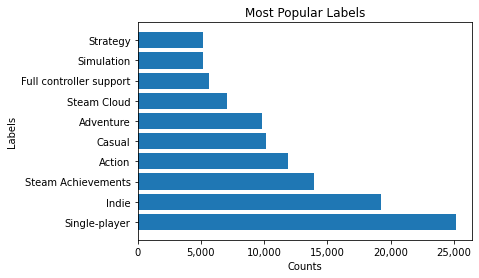

In [99]:
#barplot of the top 10 labels sorted by count
fig, ax = plt.subplots()

top_10_labels = labels_sorted[:10]

labels = [label[0] for label in top_10_labels]
counts = [label[1] for label in top_10_labels]

ax.barh(labels, counts)

#format x-axis to improve readability
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(
                                   lambda x, p : format(int(x), ',')))

ax.set_ylabel('Labels')
ax.set_xlabel('Counts')
ax.set_title('Most Popular Labels');

#plt.savefig('popular_labels.png', dpi=300)

With the labels cleaned, I proceeded with encoding the labels into numerical values.

Each game in the dataframe was converted into a vector with each label representing a different dimension. My content based recommender uses cosine similarity between these game vectors to determine similarity based on the dimensions specified by numerically encoded content labels. I used sklearn's MultiLabelBinarizer to create a dataframe with every game as a row and every label as a column. For each column, a game was assigned a 0 if it did not have that label and a 1 if it did have the label. 

In [100]:
def create_mlb_df(df, columns):
    '''
    Uses MultiLabelBinarizer to transform specified columns and return a dataframe of encoded values
    
    Arguments:
    df: dataframe 
    columns: list of column names to encode
    
    Returns:
    new dataframe consisting of MultiLabelBinarizer transformed values
    '''
    #create a new empty dataframe with the same index as df
    new_df = pd.DataFrame(index=df.index)
    for column in columns:
        #instantiate a new MultiLabelBinarizer object
        mlb = MultiLabelBinarizer()
        mlb_array = mlb.fit_transform(df[column])
        mlb_df = pd.DataFrame(mlb_array, df.index, mlb.classes_)
        #concatenate each dataframe of encoded values by column
        new_df = pd.concat([new_df, mlb_df], axis=1)
    return new_df

In [101]:
mlb_df = create_mlb_df(clean_df, ['labels'])
mlb_df

,1980s,1990's,2.5D,2D,2D Fighter,360 Video,3D,3D Platformer,3D Vision,4 Player Local,...,Wargame,Warhammer 40K,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,e-sports
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27071,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27072,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27073,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [102]:
list(mlb_df.columns)

['1980s',
 "1990's",
 '2.5D',
 '2D',
 '2D Fighter',
 '360 Video',
 '3D',
 '3D Platformer',
 '3D Vision',
 '4 Player Local',
 '4X',
 '6DOF',
 'Abstract',
 'Action',
 'Action RPG',
 'Action-Adventure',
 'Adventure',
 'Agriculture',
 'Aliens',
 'Alternate History',
 'America',
 'Anime',
 'Arcade',
 'Arena Shooter',
 'Assassin',
 'Atmospheric',
 'BMX',
 'Base-Building',
 'Baseball',
 'Basketball',
 'Batman',
 'Battle Royale',
 "Beat 'em up",
 'Beautiful',
 'Benchmark',
 'Bikes',
 'Blood',
 'Board Game',
 'Bowling',
 'Building',
 'Bullet Hell',
 'Bullet Time',
 'CRPG',
 'Capitalism',
 'Card Game',
 'Cartoon',
 'Cartoony',
 'Casual',
 'Cats',
 'Character Action Game',
 'Character Customization',
 'Chess',
 'Choices Matter',
 'Choose Your Own Adventure',
 'Cinematic',
 'City Builder',
 'Class-Based',
 'Classic',
 'Clicker',
 'Co-op',
 'Cold War',
 'Colorful',
 'Comedy',
 'Comic Book',
 'Competitive',
 'Controller',
 'Conversation',
 'Crafting',
 'Crime',
 'Cross-Platform Multiplayer',
 'Cult 

The output of the recommender is going to use clean_df to display information for each recommended game. To provide a better user experience, I dropped some columns and renamed the columns.

In [103]:
clean_df.head()

,appid,name,release_date,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,owners,price,percent_positive,labels
0,10,Counter-Strike,2000-11-01,Valve,Valve,"[windows, mac, linux]",0,"[Multi-player, Online Multi-Player, Local Mult...",[Action],"[Action, FPS, Multiplayer]",10000000-20000000,7.19,0.973888,"[Action, FPS, Local Multi-Player, Multi-player..."
1,20,Team Fortress Classic,1999-04-01,Valve,Valve,"[windows, mac, linux]",0,"[Multi-player, Online Multi-Player, Local Mult...",[Action],"[Action, FPS, Multiplayer]",5000000-10000000,3.99,0.839787,"[Action, FPS, Local Multi-Player, Multi-player..."
2,30,Day of Defeat,2003-05-01,Valve,Valve,"[windows, mac, linux]",0,"[Multi-player, Valve Anti-Cheat enabled]",[Action],"[FPS, World War II, Multiplayer]",5000000-10000000,3.99,0.895648,"[Action, FPS, Multi-player, World War II]"
3,40,Deathmatch Classic,2001-06-01,Valve,Valve,"[windows, mac, linux]",0,"[Multi-player, Online Multi-Player, Local Mult...",[Action],"[Action, FPS, Multiplayer]",5000000-10000000,3.99,0.826623,"[Action, FPS, Local Multi-Player, Multi-player..."
4,50,Half-Life: Opposing Force,1999-11-01,Gearbox Software,Valve,"[windows, mac, linux]",0,"[Single-player, Multi-player, Valve Anti-Cheat...",[Action],"[FPS, Action, Sci-fi]",5000000-10000000,3.99,0.947996,"[Action, FPS, Multi-player, Sci-fi, Single-pla..."


In [104]:
#drop unecessary information
columns_to_drop = ['categories', 'genres', 'steamspy_tags']
clean_df.drop(columns = columns_to_drop, inplace=True)

In [105]:
clean_df.head()

,appid,name,release_date,developer,publisher,platforms,required_age,owners,price,percent_positive,labels
0,10,Counter-Strike,2000-11-01,Valve,Valve,"[windows, mac, linux]",0,10000000-20000000,7.19,0.973888,"[Action, FPS, Local Multi-Player, Multi-player..."
1,20,Team Fortress Classic,1999-04-01,Valve,Valve,"[windows, mac, linux]",0,5000000-10000000,3.99,0.839787,"[Action, FPS, Local Multi-Player, Multi-player..."
2,30,Day of Defeat,2003-05-01,Valve,Valve,"[windows, mac, linux]",0,5000000-10000000,3.99,0.895648,"[Action, FPS, Multi-player, World War II]"
3,40,Deathmatch Classic,2001-06-01,Valve,Valve,"[windows, mac, linux]",0,5000000-10000000,3.99,0.826623,"[Action, FPS, Local Multi-Player, Multi-player..."
4,50,Half-Life: Opposing Force,1999-11-01,Gearbox Software,Valve,"[windows, mac, linux]",0,5000000-10000000,3.99,0.947996,"[Action, FPS, Multi-player, Sci-fi, Single-pla..."


In [106]:
#round the percentage of positive ratings
percentages = clean_df['percent_positive']
clean_percentages = [round(x * 100,2) for x in percentages.values]
clean_df['percent_positive'] = clean_percentages
clean_df.head()

,appid,name,release_date,developer,publisher,platforms,required_age,owners,price,percent_positive,labels
0,10,Counter-Strike,2000-11-01,Valve,Valve,"[windows, mac, linux]",0,10000000-20000000,7.19,97.39,"[Action, FPS, Local Multi-Player, Multi-player..."
1,20,Team Fortress Classic,1999-04-01,Valve,Valve,"[windows, mac, linux]",0,5000000-10000000,3.99,83.98,"[Action, FPS, Local Multi-Player, Multi-player..."
2,30,Day of Defeat,2003-05-01,Valve,Valve,"[windows, mac, linux]",0,5000000-10000000,3.99,89.56,"[Action, FPS, Multi-player, World War II]"
3,40,Deathmatch Classic,2001-06-01,Valve,Valve,"[windows, mac, linux]",0,5000000-10000000,3.99,82.66,"[Action, FPS, Local Multi-Player, Multi-player..."
4,50,Half-Life: Opposing Force,1999-11-01,Gearbox Software,Valve,"[windows, mac, linux]",0,5000000-10000000,3.99,94.80,"[Action, FPS, Multi-player, Sci-fi, Single-pla..."


In [107]:
#adjust owners for readability
clean_owners = []
owners = clean_df['owners']
for x in owners.values:
    lower_and_upper = x.split('-')
    #reformat numbers to include commas every 3 digits
    new_range = '{:,}'.format(int(lower_and_upper[0])) + ' - ' '{:,}'.format(int(lower_and_upper[1]))
    clean_owners.append(new_range)
clean_df['owners'] = clean_owners

In [108]:
clean_df.head()

,appid,name,release_date,developer,publisher,platforms,required_age,owners,price,percent_positive,labels
0,10,Counter-Strike,2000-11-01,Valve,Valve,"[windows, mac, linux]",0,"10,000,000 - 20,000,000",7.19,97.39,"[Action, FPS, Local Multi-Player, Multi-player..."
1,20,Team Fortress Classic,1999-04-01,Valve,Valve,"[windows, mac, linux]",0,"5,000,000 - 10,000,000",3.99,83.98,"[Action, FPS, Local Multi-Player, Multi-player..."
2,30,Day of Defeat,2003-05-01,Valve,Valve,"[windows, mac, linux]",0,"5,000,000 - 10,000,000",3.99,89.56,"[Action, FPS, Multi-player, World War II]"
3,40,Deathmatch Classic,2001-06-01,Valve,Valve,"[windows, mac, linux]",0,"5,000,000 - 10,000,000",3.99,82.66,"[Action, FPS, Local Multi-Player, Multi-player..."
4,50,Half-Life: Opposing Force,1999-11-01,Gearbox Software,Valve,"[windows, mac, linux]",0,"5,000,000 - 10,000,000",3.99,94.80,"[Action, FPS, Multi-player, Sci-fi, Single-pla..."


In [110]:
def unlist_column(column):
    '''
    Arguments:
    column: pandas series containing values with lists of strings
    '''
    new_column_value = []
    for array in column.values:
        new_str = ''
        for i in range(len(array)):
            if i != len(array) - 1:
                new_str = new_str + array[i] + ', '
            else:
                new_str = new_str + array[i]
        new_column_value.append(new_str)
    return new_column_value

In [112]:
#capitalize platforms
capitalized_arrays = []
for platforms in clean_df['platforms'].values:
    new_array = [x.capitalize() for x in platforms]
    capitalized_arrays.append(new_array)
capitalized_arrays
clean_df['platforms'] = capitalized_arrays

In [113]:
#convert the list values into string values
clean_df['platforms'] = unlist_column(clean_df['platforms'])
clean_df['labels'] = unlist_column(clean_df['labels'])
clean_df.head()

,appid,name,release_date,developer,publisher,platforms,required_age,owners,price,percent_positive,labels
0,10,Counter-Strike,2000-11-01,Valve,Valve,"Windows, Mac, Linux",0,"10,000,000 - 20,000,000",7.19,97.39,"Action, FPS, Local Multi-Player, Multi-player,..."
1,20,Team Fortress Classic,1999-04-01,Valve,Valve,"Windows, Mac, Linux",0,"5,000,000 - 10,000,000",3.99,83.98,"Action, FPS, Local Multi-Player, Multi-player,..."
2,30,Day of Defeat,2003-05-01,Valve,Valve,"Windows, Mac, Linux",0,"5,000,000 - 10,000,000",3.99,89.56,"Action, FPS, Multi-player, World War II"
3,40,Deathmatch Classic,2001-06-01,Valve,Valve,"Windows, Mac, Linux",0,"5,000,000 - 10,000,000",3.99,82.66,"Action, FPS, Local Multi-Player, Multi-player,..."
4,50,Half-Life: Opposing Force,1999-11-01,Gearbox Software,Valve,"Windows, Mac, Linux",0,"5,000,000 - 10,000,000",3.99,94.80,"Action, FPS, Multi-player, Sci-fi, Single-player"


In [126]:
#rename columns for readability
column_mapper = {'appid': 'App ID',
                 'name': 'Name',
                 'release_date': 'Release Date',
                 'developer': 'Developer',
                 'publisher': 'Publisher',
                 'platforms': 'Platforms',
                 'required_age': 'Required Age',
                 'owners': 'Owners',
                 'price': 'Price (GBP)',
                 'percent_positive': '% of Positive Ratings',
                 'labels': 'Content Labels'}
clean_df.rename(columns = column_mapper, inplace=True)
clean_df.head()

,App ID,Name,Release Date,Developer,Publisher,Platforms,Required Age,Owners,Price (GBP),% of Positive Ratings,Content Labels
0,10,Counter-Strike,2000-11-01,Valve,Valve,"Windows, Mac, Linux",0,"10,000,000 - 20,000,000",7.19,97.39,"Action, FPS, Local Multi-Player, Multi-player,..."
1,20,Team Fortress Classic,1999-04-01,Valve,Valve,"Windows, Mac, Linux",0,"5,000,000 - 10,000,000",3.99,83.98,"Action, FPS, Local Multi-Player, Multi-player,..."
2,30,Day of Defeat,2003-05-01,Valve,Valve,"Windows, Mac, Linux",0,"5,000,000 - 10,000,000",3.99,89.56,"Action, FPS, Multi-player, World War II"
3,40,Deathmatch Classic,2001-06-01,Valve,Valve,"Windows, Mac, Linux",0,"5,000,000 - 10,000,000",3.99,82.66,"Action, FPS, Local Multi-Player, Multi-player,..."
4,50,Half-Life: Opposing Force,1999-11-01,Gearbox Software,Valve,"Windows, Mac, Linux",0,"5,000,000 - 10,000,000",3.99,94.80,"Action, FPS, Multi-player, Sci-fi, Single-player"


I ask the user to supply the game that they want recommendations similar to as well as other information to refine the recommender.

In [127]:
def game_input(df):
    '''
    Function asking the user to input the name or app id of the game to find recommendations for
    Requires exact spelling of name
    Returns the index of the game in the dataframe
    
    Arguments:
    df: dataframe containing game info, recommender returns a subset of this dataframe
    '''
    game = input('Please type the name of the game you would like recommendations for: ')
    if type(game) is str:
        #search dataframe for all indices corresponding to the game name
        game_idx = df[df['Name'] == game].index
        #name is not necessarily unique
        #prompts the user to enter appid to identify the game
        if len(game_idx) > 1:
            shared_names = df[df['Name'] == game]
            print(shared_names)
            game_id = int(input('There are multiple games with this name. Please enter the app id of the game.'))
            game_idx = df[df['App ID'] == game_id].index
            game_name = df.loc[game_idx]['Name'].values[0]
            print(f'Looking for recommendations for {game_name} (app id {game_id}):')
        #if there is only one game with the name, proceed to the else statement
        else:
            game_idx = df[df['Name'] == game].index
            game_name = df.loc[game_idx]['Name'].values[0]
            game_id = df.loc[game_idx]['App ID'].values[0]
            print(f'Looking for recommendations for {game_name} (app id {game_id}):')
    #exception if input does not match any games within the dataframe
    if len(game_idx) == 0:
        return('Sorry, recommendations are not available for this game!')
    return game_idx

In [128]:
def number_recs():
    '''
    Function asking the user to input number of recommendations desired
    Input should be an integer
    Limited max recommendations to 50
    '''
    n = input('How many recommendations do you want? ')
    try:
        n = int(n)
    except:
        print('Please enter a valid number.')
        n = number_recs()
    if n == 0:
        print('Please pick a nonzero number.')
        n = number_recs()
    if n > 50:
        print('Too many recommendations, please pick a smaller number.')
        n = number_recs()
    return n

In [129]:
def content_recommendation(game_idx, content_matrix, df, n):
    '''
    Returns a dataframe containing game info for recommendations with the highest cosine similarity scores
    Adds similarity score as a column to the output dataframe
    
    Arguments:
    game_idx: index of the game from the dataframe, supplied by game_input() function
    content_matrix: encoded matrix of game features
    df: dataframe containing game info, recommender returns a subset of this dataframe
    n: number of recommendations

    '''
    #get the index of the game from the games info dataframe
    #get the features for the game from the content matrix
    game_features = content_matrix.loc[game_idx]
    #drop the game from the content matrix
    other_games_df = content_matrix.drop(game_idx, axis=0)
    #compute cosine similarity with sklearn
    cos_sim = cosine_similarity(game_features, other_games_df)
    #transform array of cos_sims into dataframe
    cos_sim_df = pd.DataFrame(cos_sim, index=game_idx, 
                              columns=other_games_df.index).T
    cos_sim_df.sort_values(by=[game_idx[0]], ascending=False, inplace=True)
    top_matches = cos_sim_df.iloc[:n]
    #get the index for each recommended game
    top_idx = top_matches.index
    #refer to full games info matrix to return info for recommended games
    rec_df = df.loc[top_idx]
    #add the similarity scores as a column to the output df
    #rename column name from game_idx to 'Similarity Score'
    scores_df = top_matches.rename(columns={top_matches.columns[0]: 'Similarity Score'})
    rec_df = pd.concat([rec_df, scores_df], axis=1)
    return rec_df

In [131]:
game_name = game_input(clean_df)
n = number_recs()
example = content_recommendation(game_name, mlb_df, clean_df, n)
example

Please type the name of the game you would like recommendations for: Stardew Valley
Looking for recommendations for Stardew Valley (app id 413150):
How many recommendations do you want? 5


,App ID,Name,Release Date,Developer,Publisher,Platforms,Required Age,Owners,Price (GBP),% of Positive Ratings,Content Labels,Similarity Score
7698,431180,WolfQuest,2016-03-25,eduweb,eduweb,"Windows, Mac",0,"50,000 - 100,000",6.99,88.80,"Co-op, Indie, Multi-player, Partial Controller...",0.843274
25754,984560,HEARTBEAT,2018-12-12,CHUMBOSOFT LLC,CHUMBOSOFT LLC,"Windows, Mac, Linux",0,"0 - 20,000",11.39,97.84,"Indie, Partial Controller Support, Pixel Graph...",0.836660
7739,432010,World's Dawn,2016-01-25,Wayward Prophet,Wayward Prophet,Windows,0,"20,000 - 50,000",6.99,81.63,"Casual, Indie, Partial Controller Support, RPG...",0.782624
1493,220260,Farming Simulator 2013 Titanium Edition,2013-10-09,Giants Software,Giants Software,"Windows, Mac",0,"500,000 - 1,000,000",11.39,91.23,"Casual, Co-op, Multi-player, Partial Controlle...",0.782624
26510,1022280,CosPuzzle: Giu Hellsing,2019-03-07,AnimeBomb,AnimeBomb,Windows,0,"0 - 20,000",0.79,50.00,"Casual, Indie, Partial Controller Support, RPG...",0.782624


# Collaborative Recommender

A collaborative recommender uses user ratings to compare users and predict how a user would rate items that they haven't used before. Typically, reviews are a good source of explicit user ratings. However, there are a few issues with using product reviews, espeically for the Steam storefront. First, the model would require a user to review products before it could compare that user to others. Not all users are interested in leaving ratings. Secondly, Steam's review system is a binary Recommended / Not Recommended rating system. This limits rating to one of two states and doesn't gauge how much a user might prefer one game to another. 

I chose to utilize user playtimes of games as an implicit rating system to create my collaborative recommender. Since users  play their purchased games through Steam's client, Steam is constantly collecting information from the user about how long they play games in their library. Playtime can be viewed as a measure of enjoyment. The more I enjoy a game, the more time I would spend playing it. Conversely, if I try a game and don't like it, I would spend less playtime with it.

One issue with using playtime is that different games demand different amounts of playtime. Similar to how books have different page counts, games are designed around estimated completion times. For example, let's say that I have two games: Game A is short and I completed it in 10 hours while Game B is long and took 50 hours to complete. Even if I like Game A enough to play through it multiple times, the total time I spend on Game A might still be less than the time I spend on Game B. Some games, such as MMOs, are designed as live-service products with constant updates that encourage the user to spend hours upon end on the same game. Using absolute playtime as an implicit metric for user rating of games will favor longer games. Every minute spent playing a game has the same value, regardless of which game is being played.

Rather than using absolute playtime, I scaled playtimes of games against the average user playtime. This compensates for the differences in game length. An absolute playtime recommender would use raw minutes to determine player enjoyment. With a standardized playtime metric, I'm saying that a user who has played more than the average playtime enjoys the game more. One issue with this system is that players who have spent less than the average are interpreted as having a lower rating of the game. A player who has just started a game might really enjoy the game, but this standardized implicit rating interprets their lower playtime as dissatisfaction. However, we could assume that users are shopping for new games because they want to play something other than their owned library. 

### Steam User Libraries - Steam Web API

I used Steam's Web API service to collect information on users and their personal libraries of games. A Web API key is required to use Steam's Web API service. You need to have a Steam Account in order to request a Web API key. 

[Here](https://steamcommunity.com/dev) is a general overview of how to access Steam's Web API. This [link](https://developer.valvesoftware.com/wiki/Steam_Web_API) has more documentation on different types of API calls and what kinds of information is available.

I used the GetOwnedGames API to return a list of games owned by a player along with playtime information for those games. The API returned data in the form of a JSON object.

One difficulty in acquiring player data through Steam's Web API is that the API call requires the Steam ID of the player. I was unable to find a public source of Steam IDs. I adressed this problem by randomly generating a list of possible Steam IDs (using my knowledge of Steam ID format) to make API calls with. Since Steam IDs are generated in chronological order (later users have 'larger' Steam IDs), the data I collected is a subset of total Steam users and may display trends that are not indicative of the larger Steam userbase.

In [132]:
#generating random steam ids
rng = np.random.RandomState(42)
random_ids = rng.randint(0, 999_000_000, size=200_000)
random_ids = random_ids.tolist()
#my own Steam ID starts with 76_561_199_###_###_###
random_ids = [76_561_198_000_000_000 + i for i in random_ids]
random_ids[:10]

[76561198534895718,
 76561198199900595,
 76561198862061404,
 76561198787846414,
 76561198996406378,
 76561198127521863,
 76561198423734972,
 76561198415968276,
 76561198670094950,
 76561198841095289]

Another challenge was user privacy settings. A user's profile must be publicly visible in order for the API to return information. Since profiles are set to private by default, many of my API calls did not return information. This limited the number of user profiles I was able to collect.

I wrote several functions to make API calls from a Jupyter notebook.

In [133]:
def make_api_call(account_list):
    '''
    Attempts to make API calls using IDs provided,
    stores results in a dictionary with each account as a key and the contents of the api call as the value
    
    Arguments:
    account_list: a list of possible Steam User IDs
    '''
    users = {}
    for account in account_list:
        api_call = f'http://api.steampowered.com/IPlayerService/GetOwnedGames/v0001/?key={key}&steamid={account}&include_appinfo=1&format=json'
        user_data = requests.get(api_call).json()
        users[account] = user_data
    return users

The Steam Web API URL requires an API key. I saved my API key in a text file in my local repository. For privacy reasons, I will not be providing an API key in my project repository.

In [ ]:
#key = './SteamWebAPIKey.txt'
with open(key, 'r') as file:
    key = file.read()

Occasionally, the API would return no user data, either because the user was private or there was an issue with the API call. I wrote a function to remove empty dictionaries from the API call results.

In [ ]:
def clean_api_data(api_dict):
    '''
    Takes results of API calls for various users and adds results to a new dictionary only if the result was not an 
    empty dictionary
    
    Arguments:
    api_dict: list of dictionaries containing user information from the API calls 
    '''
    empty_dict = {}
    account_dict = {}
    for k in api_dict.keys():
        if api_dict[k]['response'] != empty_dict:
            if api_dict[k]['response']['game_count'] != 0:
                #keys are set as strings to match json files when read in
                account_dict[str(k)] = api_dict[k]['response']
    return account_dict

In [ ]:
def append_json(clean_dict, filename):
    '''
    Function to open a json file and append the API call results 
    
    Arguments:
    clean_dict: a dictionary containing responses from the API call that were not empty
    filename: name JSON file to append to
    '''
    with open(filename, 'r') as file:
        saved_players = json.load(file)
    for k,v in clean_dict.items():
        saved_players[k] = v
    with open(filename, 'w') as file:
        json.dump(saved_players, file)

The data collected was stored as a JSON file and is available in the data folder of this project's GitHub repository.

In [135]:
f = './data/Steam_API_Owned_Games.json'
with open(f, 'r') as file:
    saved_players = json.load(file)

In [137]:
len(saved_players)

2981

In [145]:
first_user = list(saved_players.keys())[0]
saved_players[first_user]

{'game_count': 24,
 'games': [{'appid': 4000,
   'name': "Garry's Mod",
   'playtime_forever': 2648,
   'img_icon_url': '4a6f25cfa2426445d0d9d6e233408de4d371ce8b',
   'has_community_visible_stats': True,
   'playtime_windows_forever': 0,
   'playtime_mac_forever': 0,
   'playtime_linux_forever': 0,
   'rtime_last_played': 1559592042},
  {'appid': 200210,
   'name': 'Realm of the Mad God Exalt',
   'playtime_forever': 67,
   'img_icon_url': '76c62602486e58f9501e09e7e8f189e86823e8d5',
   'has_community_visible_stats': True,
   'playtime_windows_forever': 0,
   'playtime_mac_forever': 0,
   'playtime_linux_forever': 0,
   'rtime_last_played': 1565631924},
  {'appid': 253710,
   'name': 'theHunter Classic',
   'playtime_forever': 0,
   'img_icon_url': '4a91dc770675e559038a4f46e0daa4f8fa42ee30',
   'has_community_visible_stats': True,
   'playtime_windows_forever': 0,
   'playtime_mac_forever': 0,
   'playtime_linux_forever': 0,
   'rtime_last_played': 0},
  {'appid': 252490,
   'name': 'Ru

In [146]:
#datatype of value mapped to game_count
type(saved_players[first_user]['game_count'])

int

Each value in the JSON file is a dictionary with two keys: 'game_count' and 'games'. 

The value mapped to 'game_count' is an integer describing the number of games owned by that user. 

The value mapped to 'games' is a list of dictionaries. Each dictionary in this list describes a game in the user's library and contains the user's playtime information recorded in minutes. Playtime is split across platforms (Windows, Mac, Linux) but also includes a value for 'playtime_forever'. I noticed that while platform playtimes did not add up to 'playtime_forever', the value of 'playtime_forever' was always greater than or equal to the sum of platform playtimes. This meant that 'playtime_forever' was the value I would use to measure playtime per game per user.

For some games, the total playtime is 0. This indicates that the user owns the game in their library but has not played it. This is useful information for the recommender system since I don't want to recommend a game to a user if they already own it. However, there were some users in this data with no playtime recorded for any game. I removed them from the data since this meant they essentially had no ratings to provide to the recommender.

I separated the json data into two separate dictionaries

Users dictionary:
* Contains user ID as the key
* Value is another dictionary with appid of library games as keys and 'playtime_forever' for each game as values

Games dictioanry:
* AppID of games as keys
* Value is another dictionary with two keys
    * 'name' : the name of the game
    * 'playtimes' : playtime values for each user who has played the game

In [148]:
#setting up users and games dictionaries
users_dict = {}
games_dict = {}
#user is the account id as a string
#stats is a dictionary containing information of playtime for each game in the user's Steam library
for user, stats in saved_players.items():
    library_dict = {}
    #user_library is a list of dictionaries with each dictionary corresponding to a game played
    user_library = stats['games']
    #each dictionary in this list contains data on a game played for the user
    for game in user_library:
        #ignore games with 0 playtime
        if game['playtime_forever'] > 0:
            #store the playtime (minutes) for each game into the library dict for a user
            library_dict[game['appid']] = game['playtime_forever']
            #store the game identifiers and playime in the games_dict
            if game['appid'] not in games_dict:
                games_dict[game['appid']] = {'name': game['name'], 'playtimes': [game['playtime_forever']]}
            else:
                games_dict[game['appid']]['playtimes'].append(game['playtime_forever'])
    users_dict[user] = library_dict

In [151]:
len(users_dict)

2981

In [152]:
#examine the first user in the users_dict
first_user = list(users_dict.keys())[0]
print(first_user)
print(users_dict[first_user])

76561198199900595
{4000: 2648, 200210: 67, 252490: 307823, 252950: 57178, 282660: 156, 301520: 304, 291480: 1173, 227940: 220, 730: 98149, 397900: 1748, 299360: 93, 447020: 3734, 550650: 5, 506540: 20, 359550: 1579, 787860: 13266, 582010: 41, 1080110: 166, 1248130: 9443, 823130: 199, 1517290: 3880}


In [154]:
#removing players with no playtime data from the dataset
users_dict = {user:library for (user, library) in users_dict.items() if library != {}}
len(users_dict)

2449

In [158]:
#example of games_dict structure
games_dict[945360]

{'name': 'Among Us',
 'playtimes': [1982,
  52,
  1777,
  1982,
  1260,
  1710,
  734,
  2930,
  3435,
  1996,
  843,
  707,
  67,
  113,
  3,
  2903,
  154,
  117,
  5479,
  2908,
  792,
  1743,
  784,
  919,
  2713,
  312,
  570,
  3598,
  600,
  236,
  186,
  2327,
  506,
  118,
  1966,
  253,
  223,
  1231,
  4608,
  87,
  1013,
  364,
  2415,
  4,
  16,
  1171,
  134,
  746,
  137,
  584,
  137,
  3110,
  1767,
  1457,
  115,
  6004,
  543,
  497,
  117,
  1915,
  4431,
  427,
  760,
  1898,
  50,
  1066,
  1120,
  4685,
  615,
  2832,
  8347,
  1201,
  3549,
  869,
  4587,
  1653,
  1051,
  2010,
  3121,
  58,
  758,
  1369,
  1847,
  86,
  1865,
  556,
  2117,
  563,
  475,
  99,
  970,
  1132,
  269,
  2365,
  863,
  377,
  244,
  38,
  27010,
  2828,
  916,
  340,
  610,
  25,
  754,
  1773,
  1063,
  982,
  4881,
  185,
  1852,
  52,
  577,
  3618,
  874,
  481,
  1590,
  3240,
  833,
  289,
  13399,
  656,
  3425,
  84,
  142,
  767,
  712,
  390,
  406,
  1946,
  766,
  446

To create standardized playtimes, I calculated the mean and median playtimes for every game. I made additional dictionaries to visualize the top playtimes.

In [169]:
median_dict = {}
mean_dict = {}
for game in games_dict:
    #calculate average and median playtimes for each game
    median_dict[game] = np.median(games_dict[game]['playtimes'])
    mean_dict[game] = np.mean(games_dict[game]['playtimes'])

In [174]:
sorted_medians = sorted(median_dict.items(), key=operator.itemgetter(1), reverse=True)
top_10_medians = sorted_medians[:10]
top_10_medians

[(919220, 315249.0),
 (528200, 271438.0),
 (843660, 162616.0),
 (346730, 159137.0),
 (1173510, 86142.5),
 (378120, 37693.0),
 (105430, 28335.5),
 (676500, 26394.0),
 (548290, 26193.0),
 (231670, 23150.0)]

In [175]:
sorted_means = sorted(mean_dict.items(), key=operator.itemgetter(1), reverse=True)
top_10_means = sorted_means[:10]
top_10_means

[(919220, 315249.0),
 (528200, 271438.0),
 (843660, 162616.0),
 (346730, 159137.0),
 (1173510, 86142.5),
 (1267910, 46862.0),
 (551170, 40489.666666666664),
 (1263850, 39556.333333333336),
 (1371580, 34254.25),
 (325180, 28745.636363636364)]

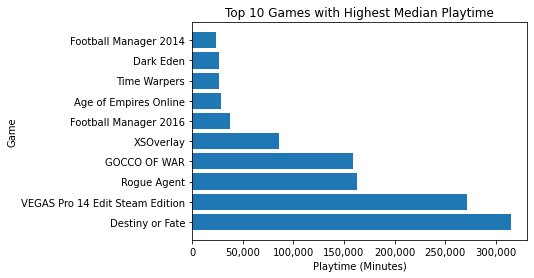

In [182]:
fig, ax = plt.subplots()

x = [games_dict[game[0]]['name'] for game in top_10_medians]
y = [game[1] for game in top_10_medians]

ax.barh(x, y)

#format x-axis to improve readability
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(
                                   lambda x, p : format(int(x), ',')))
ax.set_xlabel('Playtime (Minutes)')
ax.set_ylabel('Game')
ax.set_title('Top 10 Games with Highest Median Playtime');

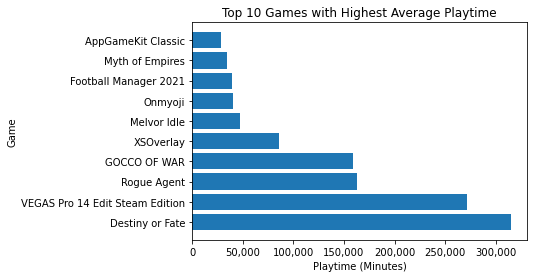

In [183]:
fig, ax = plt.subplots()

x = [games_dict[game[0]]['name'] for game in top_10_means]
y = [game[1] for game in top_10_means]

ax.barh(x, y)

#format x-axis to improve readability
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(
                                   lambda x, p : format(int(x), ',')))
ax.set_xlabel('Playtime (Minutes)')
ax.set_ylabel('Game')
ax.set_title('Top 10 Games with Highest Average Playtime');

I created two additional dictionaries containing standardized playtimes for each user. The keys of these dictionaries was user IDs; the value mapped to each user ID was a dictionary with app IDs as keys and standardized playtimes as values.

In [159]:
#standardize playtime by median
users_median_dict = {}
for user, library in users_dict.items():
    standardized_library = {}
    for game in library:
        standardized_time = library[game] / games_dict[game]['median']
        standardized_library[game] = standardized_time
    users_median_dict[user] = standardized_library

In [161]:
users_median_dict['76561198199900595']

{4000: 1.5696502667457024,
 200210: 0.8933333333333333,
 252490: 83.53405698778833,
 252950: 30.907027027027027,
 282660: 0.7428571428571429,
 301520: 1.737142857142857,
 291480: 10.567567567567568,
 227940: 2.993197278911565,
 730: 16.820736932305056,
 397900: 6.176678445229682,
 299360: 0.543859649122807,
 447020: 3.255448997384481,
 550650: 0.0684931506849315,
 506540: 0.45454545454545453,
 359550: 0.497636306334699,
 787860: 4.572905894519131,
 582010: 0.015894553207986044,
 1080110: 0.08750658935160781,
 1248130: 5.507728200641586,
 823130: 3.0615384615384613,
 1517290: 1.578519121236778}

In [162]:
#standardize playtime by mean
users_mean_dict = {}
for user, library in users_dict.items():
    standardized_library = {}
    for game in library:
        standardized_time = library[game] / games_dict[game]['mean']
        standardized_library[game] = standardized_time
    users_mean_dict[user] = standardized_library

In [163]:
users_mean_dict['76561198199900595']

{4000: 0.2594886924909224,
 200210: 0.021191646191646193,
 252490: 14.36547503457967,
 252950: 4.277493608655611,
 282660: 0.24266962154790317,
 301520: 0.25157701476995586,
 291480: 2.732805255023184,
 227940: 0.2541124418189204,
 730: 3.566143630498645,
 397900: 3.2478450985596736,
 299360: 0.1078841612462195,
 447020: 0.3887963348604748,
 550650: 0.004364009162110241,
 506540: 0.07759852971206861,
 359550: 0.1187849388448618,
 787860: 1.487415067321461,
 582010: 0.0048254268782161784,
 1080110: 0.05342705597610588,
 1248130: 2.5717281479363265,
 823130: 0.8922890619886104,
 1517290: 1.4527104020836723}

Now that I had standardized playtimes, I could prepare the data to create a collaborative recommender using surprise.

The surprise package requires data in a specific format before modeling. If the data is provided as a dataframe, the dataframe must have 3 columns: the user identifier, the product identifier, and the rating. Each row in the dataframe is a rating for a user and a product. 

I made yet another dictionary to format my data for modeling with surprise.

In [189]:
#creating dictionary to format data for surprise modeling
surprise_dict = {}
surprise_dict['appid'] = []
surprise_dict['userid'] = []
surprise_dict['median_playtime'] = []
for key, value in users_median_dict.items(): 
    for game in value:
        surprise_dict['userid'].append(key)
        surprise_dict['appid'].append(game)
        surprise_dict['median_playtime'].append(value[game])

print(len(surprise_dict['appid']))
print(len(surprise_dict['userid']))
print(len(surprise_dict['median_playtime']))

80481
80481
80481


In [190]:
#convert median standardized dictionary to dataframe
median_df = pd.DataFrame(surprise_dict, columns=['userid', 'appid', 'median_playtime'])
median_df

,userid,appid,median_playtime
0,76561198199900595,4000,1.569650
1,76561198199900595,200210,0.893333
2,76561198199900595,252490,83.534057
3,76561198199900595,252950,30.907027
4,76561198199900595,282660,0.742857
...,...,...,...
80476,76561198009690110,897450,4.179562
80477,76561198009690110,1384030,1.000000
80478,76561198009690110,1585020,1.000000
80479,76561198009690110,1594320,1.000000


In [191]:
#repeat process for mean
surprise_dict = {}
surprise_dict['appid'] = []
surprise_dict['userid'] = []
surprise_dict['mean_playtime'] = []
for key, value in users_mean_dict.items(): 
    for game in value:
        surprise_dict['userid'].append(key)
        surprise_dict['appid'].append(game)
        surprise_dict['mean_playtime'].append(value[game])

print(len(surprise_dict['appid']))
print(len(surprise_dict['userid']))
print(len(surprise_dict['mean_playtime']))

80481
80481
80481


In [192]:
#convert mean standardized dictionary to dataframe
mean_df = pd.DataFrame(surprise_dict, columns=['userid', 'appid', 'mean_playtime'])
mean_df

,userid,appid,mean_playtime
0,76561198199900595,4000,0.259489
1,76561198199900595,200210,0.021192
2,76561198199900595,252490,14.365475
3,76561198199900595,252950,4.277494
4,76561198199900595,282660,0.242670
...,...,...,...
80476,76561198009690110,897450,2.602727
80477,76561198009690110,1384030,1.000000
80478,76561198009690110,1585020,1.000000
80479,76561198009690110,1594320,1.000000


With the data organized, I could begin modeling with surprise.

## Collaborative Recommender Modeling

In [ ]:
min_playtime = median_df['playtime'].min()

In [ ]:
max_playtime = median_df['playtime'].max()

In [ ]:
#instansiate a reader object 
reader = Reader(rating_scale=(min_playtime, max_playtime))

In [ ]:
surprise_median = Dataset.load_from_df(median_df, reader)

In [ ]:
type(surprise_median)

## Results

## Conclusions